In [1]:
# Libraries we will need today
from enum import Enum, unique
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# The simulation will use these two classes, which does not need editing.

@unique
class SEIR_State(Enum):
    """ Class representing the state of a person. """
    S = 1  # SUSCEPTIBLE
    E = 2  # EXPOSED
    I = 3  # INFECTIOUS
    R = 4  # RECOVERED

class Person:
    """  Class representing a person in the population, keeping track of 
    their state and the number of days (complete simulation steps) that the 
    person has been exposed or infected.
    
    Attributes:
        state: An SEIR_State indicating the state of the person
        days_spent_in_E: an integer number of days as exposed
        days_spent_in_I: an integer number of days as infectious
        max_days_in_E: an integer for the number of days that this person
                       stays in (E) before (I); defaults to 2 for everyone
        max_days_in_I: an integer for the number of days that this person
                       stays in (I) before (R); defaults to 14 for everyone        
    """
    def __init__(self, state):
        self.state = state
        self.days_spent_in_E = 0
        self.days_spent_in_I = 0
        self.max_days_in_E = 2
        self.max_days_in_I = 14

In [3]:
# Get a list of people for initializing the simulation. This does not need editing.

def initialize_person_list(N_S0, N_E0, N_I0, N_R0):
    """Form the initial state of the simulation.
    
    Args:
        N_S0: number of susceptible individuals
        N_E0: number of exposed individuals
        N_I0: number of infectious individuals
        N_R0: number of recovered individuals

    Returns:
        List of person objects of length equal 
        to the sum of N_S0, N_E0, N_I0, and N_R0.
    """
    
    plist = []

    for _ in range(N_S0):
        plist.append(Person(SEIR_State.S))

    for _ in range(N_E0):
        person = Person(SEIR_State.E)
        person.days_spent_in_E = np.random.choice(person.max_days_in_E - 1, 1)[0]
        plist.append(person)
        
    for _ in range(N_I0):
        person = Person(SEIR_State.I)
        person.days_spent_in_E = person.max_days_in_E
        person.days_spent_in_I = np.random.choice(person.max_days_in_I - 1, 1)[0]
        plist.append(person)
        
    for _ in range(N_R0):
        person = Person(SEIR_State.R)
        person.days_spent_in_E = person.max_days_in_E
        person.days_spent_in_E = person.max_days_in_I
        plist.append(person)
        
    return plist

In [4]:
# Main code for a step of the simulation. This needs editing.

def basic_SEIR_step(person_list, p, r, c):
    """Simulate one SEIR step.

    Args:
        person_list: list of person objects
        p: probability of contact transmission
        r: probability of infection from external source 
        c: number of others that one person comes into contact with
    """
    
    # Determine (S) people that become (E) at the end of this step.
    S_to_E = []
    
    # outside / external infections
    for (index, person) in enumerate(person_list):
        if person.state == SEIR_State.S:
            if random.random() <= r:
                S_to_E.append(index)
                
    N = len(person_list)
    # internal infections
    for (index, person) in enumerate(person_list):
        if person.state == SEIR_State.I:
            contacts = np.random.choice(N, c, replace=False)  # should also worry about whether index is sampled
            for contact in contacts:
                if person_list[contact].state == SEIR_State.S:
                    if random.random() <= p:
                        S_to_E.append(contact)
                              
    # Determine (E) people that become (I) at the end of this step.
    E_to_I = []
    for (index, person) in enumerate(person_list):
        if person.state == SEIR_State.E:
            person.days_spent_in_E += 1
            if person.days_spent_in_E == person.max_days_in_E:
                E_to_I.append(index)    

    # Determine (I) people who become (R) at the end of this step.
    I_to_R = []
    for (index, person) in enumerate(person_list):
        if person.state == SEIR_State.I:
            person.days_spent_in_I += 1
            if person.days_spent_in_I == person.max_days_in_I:
                I_to_R.append(index)    

    # Update S --> E cases
    for index in S_to_E:
        person_list[index].state = SEIR_State.E

    # Update E --> I cases
    for index in E_to_I:
        person_list[index].state = SEIR_State.I

    # Update I --> R cases        
    for index in I_to_R:
        person_list[index].state = SEIR_State.R

In [5]:
# Basic loop for the simulation. This needs editing.

def run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T):
    """Simulate T SEIR steps.
    
    Args:
        N_S0: number of susceptible individuals at initialization
        N_E0: number of exposed individuals at initialization
        N_I0: number of infectious individuals at initialization
        N_R0: number of recovered individuals at initialization  
        p: probability of contact transmission
        r: probability of infection from external source 
        c: number of others with whom an (I) person initiates contact
        T: number of time steps
    
    Returns:
        number of newly exposed individuals at each step
    """
    
    person_list = initialize_person_list(N_S0, N_E0, N_I0, N_R0)
    
    # 0/1 array of who has ever been exposed
    has_been_exposed = [0 for _ in range(len(person_list))]
    for (index, person) in enumerate(person_list):
        if person.state in [SEIR_State.E, SEIR_State.I, SEIR_State.R]:
            has_been_exposed[index] = 1
    num_init_exposed = sum(has_been_exposed)
    
    num_exposed = [num_init_exposed]
    # Run simulation steps
    for t in range(T):
        basic_SEIR_step(person_list, p, r, c)
        for (index, person) in enumerate(person_list):
            if person.state in [SEIR_State.E, SEIR_State.I, SEIR_State.R]:
                has_been_exposed[index] = 1
        num_exposed.append(sum(has_been_exposed))

    return [num_exposed[j] - num_exposed[j - 1] for j in range(1, T)]

Now, let's run the simulation. To do this, we need to set our parameters.

First, determine some reasonable parameter settings. Then, make a plot that shows the number of newly exposed individuals at each time step for $T = 100$ time steps. Make another plot that shows the cumulative fraction of initially susceptible individuals that have become exposed at any point (numpy's <a href="https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html">cumsum function</a> may be useful).

In [6]:
# Make plots here (need to edit code above)
N_S0 = 970
N_E0 = 10
N_I0 = 10
N_R0 = 10
N = N_S0 + N_E0 + N_I0 + N_R0
p = 0.02
r = 0.001
c = 10
T = 100

newly_E = run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T)

Text(0, 0.5, 'Number of new (E)')

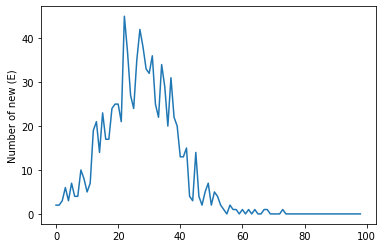

In [7]:
plt.plot(newly_E)
plt.ylabel("Number of new (E)")

Text(0, 0.5, 'Cumulative fraction (E)')

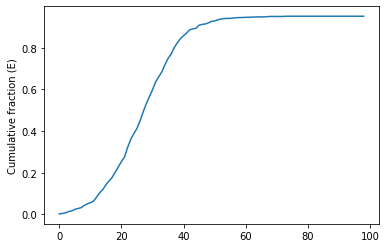

In [8]:
plt.plot(np.cumsum(newly_E) / N_S0)
plt.ylabel("Cumulative fraction (E)")

Next, let's examine the *sensitivity* of our model by seeing how the output responds to certain changes in the input. Make the same plots as before, but overlay curves for varying parameters:
<ol>
    <li>$c$ varies with all other parameters fixed</li>
    <li>$p$ varies with all other parameters fixed</li>
    <li>$r$ varies with all other parameters fixed</li>
</ol>

Text(0, 0.5, 'Number of new (E)')

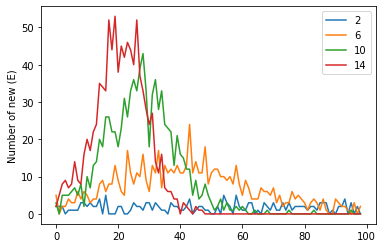

In [9]:
# number of contacts c varying
for new_c in np.arange(2, 15, 4):
    newly_E = run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, new_c, T)
    plt.plot(newly_E, label=new_c)
plt.legend()
plt.ylabel("Number of new (E)")

Text(0, 0.5, 'Cumulative fraction (E)')

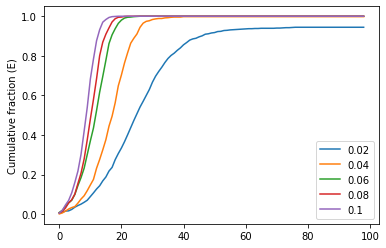

In [10]:
# infection probability p varying
for new_p in np.arange(0.02, 0.11, 0.02):
    newly_E = run_simulation(N_S0, N_E0, N_I0, N_R0, new_p, r, c, T)
    plt.plot(np.cumsum(newly_E) / N_S0, label=new_p)
plt.legend()
plt.ylabel("Cumulative fraction (E)")

### Basic reproductive number

An epidemiological term you may have heard in the news is $R_0$, pronounced like R-naught or R-zero, which is also sometimes called the basic reproductive number. This is the average number of new infections caused by a single individual who becomes infected. At a high level, if $R_0 < 1$, then the virus will tend to die out and if $R_0 > 1$, the virus will go on to infect most of the population (see the Easley and Kleinberg reading for some of the mathematics). One <a href="https://www.nejm.org/doi/full/10.1056/nejmoa2001316">study</a>
estimated $R_0 \approx 2.2$ in early covid-19 spread.

If $r = 0.0$, we would expect an $R_0$ to be a bit less than $14 \cdot cp$ (why?). Try $14 \cdot cp = 2.0$ and $14 \cdot cp = 0.75$ and see how much of the population becomes exposed.

In [11]:
# Test of R_0
r = 0.0
(sum(run_simulation(N_S0, N_E0, N_I0, N_R0, 2.0 / 14 / c, r, c, T)) / N_S0,
 sum(run_simulation(N_S0, N_E0, N_I0, N_R0, 0.75 / 14 / c, r, c, T)) / N_S0)

(0.7711340206185567, 0.03608247422680412)